In [30]:
from langgraph.graph import StateGraph, END
from typing import Dict, TypedDict, Optional, Literal, List, Union

In [31]:
class GraphState(TypedDict):
    init_input: Optional[str] = None # The initial input string from the user.
    fruit: Optional[str] = None # The validated fruit name.
    final_result: Optional[str] = None # The final result message.
    user_confirmation: Optional[str] = None  # New field for user confirmation

In [49]:


def input_fruit(state: GraphState) -> Dict[str, str]:
    print("--------------------------")
    print("Node: input_fruit()")
    init_input = state.get("init_input", "").strip().lower()
    
    # Validate the input
    valid_fruits = {"apple", "banana", "cherry"}
    if init_input in valid_fruits:
        return {"fruit": init_input}
    
    # Return error if the fruit is not valid
    return {"fruit": "error"}

# confirm_fruit: This function sets the final result when the fruit selection is confirmed by the user.
def confirm_fruit(state: GraphState) -> Dict[str, str]:
    print("--------------------------")
    print("Node: confirm_fruit()")
    return {"final_result": f"You selected {state['fruit']}, which is a valid fruit."}

# error: This function sets the final result to an error message if there is an error in the input 
# or the user rejects the selection.
def error(state: GraphState) -> Dict[str, str]:
    print("--------------------------")
    print("Node: error()")
    return {"final_result": "error"}

In [50]:
# review_fruit: This function allows the user to review their fruit selection. 
# It doesn't modify the state, but it prints a review message.
def review_fruit(state: GraphState) -> Dict[str, str]:
    print("--------------------------")
    print("Node: review_fruit()")
    print(f"Review your selection: {state['fruit']}. Is this correct?")
    return {}
# continue_next: This function determines the next node based on the state after input_fruit. 
# If the fruit is valid, it transitions to review_fruit; otherwise, it transitions to error.

# continue_next: This modified function determines the next node based on the state after input_fruit. 
# If the fruit is valid, it transitions to review_fruit; otherwise, it transitions to error.
def continue_next(state: GraphState) -> Literal["to_review_fruit", "to_error"]:
    print("--------------------------")
    print("Function Edge: continue_next:")
    print(f"Function Edge State: {state}")
    if state.get("fruit") != "error":
        print("Function Edge Continue: to_review_fruit")
        return "to_review_fruit"
    
    print("Function Edge Continue: continue to_error")
    return "to_error"

#review_decision: This function determines the next node based on the user's confirmation after reviewing the fruit. 
# If the user confirms, it transitions to confirm_fruit; otherwise, it transitions to error.
def review_decision(state: GraphState) -> Literal["to_confirm_fruit", "to_error"]:
    print("--------------------------")
    print("Function Edge: review_decision:")
    print(f"Function Edge Continue: state: {state}")
    if state.get("user_confirmation") == "yes":
        print("Function Edge Continue: to_confirm_fruit")
        return "to_confirm_fruit"
    
    print("Function Edge Continue: to_error")
    return "to_error"



In [56]:
workflow = StateGraph(GraphState)

workflow.add_node("input_fruit", input_fruit)
workflow.add_node("review_fruit", review_fruit)
workflow.add_node("confirm_fruit", confirm_fruit)
workflow.add_node("error", error)

workflow.set_entry_point("input_fruit")
workflow.add_edge("confirm_fruit", END)
workflow.add_edge("error", END)

workflow.add_conditional_edges(
    "input_fruit",  # The node where the decision is made
    continue_next,  # The function that makes the decision
    {    
        "to_review_fruit": "review_fruit",  # Mapping function output to nodes
        "to_error": "error",
    },
)

workflow.add_conditional_edges(
    "review_fruit",  # The node where the decision is made after review
    review_decision,  # The function that makes the decision after review
    {    
        "to_confirm_fruit": "confirm_fruit",  # Mapping function output to nodes
        "to_error": "error",
    },
)

In [57]:
app = workflow.compile()

In [58]:
# Test with an invalid fruit
result = app.invoke({"init_input": "mango"})
print("Result:")
print(result)

--------------------------
Node: input_fruit()
--------------------------
Function Edge: continue_next:
Function Edge State: {'fruit': 'error', 'init_input': 'mango'}
Function Edge Continue: continue to_error
--------------------------
Node: error()
Result:
{'init_input': 'mango', 'fruit': 'error', 'final_result': 'error'}


In [59]:
# Test with an invalid fruit
result = app.invoke({"init_input": "apple", "user_confirmation": "yes"})
print("Result:")
print(result)

--------------------------
Node: input_fruit()
--------------------------
Function Edge: continue_next:
Function Edge State: {'fruit': 'apple', 'init_input': 'apple', 'user_confirmation': 'yes'}
Function Edge Continue: to_review_fruit
--------------------------
Node: review_fruit()
Review your selection: apple. Is this correct?


InvalidUpdateError: Expected node init_input to update at least one of ['init_input', 'fruit', 'final_result', 'user_confirmation'], got {}

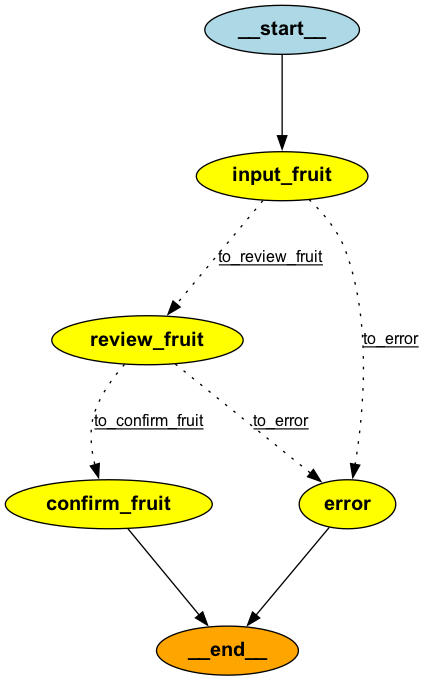

In [60]:
from IPython.display import display, Image

png_data = app.get_graph().draw_png()

# Convert the binary data to an IPython Image object with specific dimensions
image = Image(data=png_data, width=300, height=300)

# Display the image
display(image)